In [1]:
from torchvision.models import vgg
from torch_lib.Model_heading_bin import *
from torch_lib.ClassAverages import *
from torchvision import transforms
import os, glob, cv2
from library.ron_utils import *
import matplotlib.pyplot as plt
import numpy as np

def plot_regressed_3d_bbox(img, cam_to_img, box_2d, dimensions, alpha, theta_ray, detectionid):

    # the math! returns X, the corners used for constraint
    location, X = calc_location(dimensions, cam_to_img, box_2d, alpha, theta_ray)

    orient = alpha + theta_ray

    #plot_2d_box(img, box_2d, detectionid)
    plot_3d_box(img, cam_to_img, orient, dimensions, location) # 3d boxes

    return location, orient

#REG PNG TO VIDEO
import cv2, os, glob
def make_video(folder, img_paths, fps=15):
    reg_folder = os.path.join(folder, 'reg_images')
    video_name = os.path.join(folder, 'eval.avi')
    image0 = os.path.join(sub_folder, img_paths[0])
    frame = cv2.imread(image0)
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, 0, fps=fps, frameSize=(width,height))
    for i in range(len(img_paths)):
        path = os.path.join(folder, img_paths[i].replace('images', 'reg_images'))
        video.write(cv2.imread(path))
    cv2.destroyAllWindows()
    video.release()

## Init setting

In [5]:
weights_path = 'weights/DA_B4_N1_50.pkl'
device = torch.device('cuda') # 選gpu的index
checkpoint = torch.load(weights_path, map_location=device) #if training on 2 GPU, mapping on the same device
normalize_type = checkpoint['normal']
bin_num = checkpoint['bin']
angle_per_class = 2*np.pi/float(bin_num)

my_vgg = vgg.vgg19_bn(weights='DEFAULT').to(device)
model = Model(features=my_vgg.features, bins=bin_num).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# for img processing
if normalize_type == 0:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
if normalize_type == 1:
    normalize = transforms.Normalize(mean=[0.596, 0.612, 0.587], std=[0.256, 0.254, 0.257])
process = transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize([224,224], transforms.InterpolationMode.BICUBIC), 
                              normalize])

ELAN_averages = ClassAverages(average_file='all_ELAN_class_averages.txt')
cam_to_img = np.array([
        [1.418667e+03, 0.000e+00, 6.4e+02, 0],
        [0.000e+00, 1.418867e+03, 3.6e+02, 0],
        [0.000e+00, 000e+00, 1.0e+00, 0] ])
class_dict = {8:'truck', 9:'car', 10:'motor', 11:'bike'}

# Eval all folders

In [6]:
import json
valid_folder = 'IVAvalid_for_NCTU'
for time in ['day', 'night']:
    folder = f'{valid_folder}/{time}'
    for sub_f in os.listdir(folder):
        sub_folder = os.path.join(folder, sub_f)
        with open(f'{sub_folder}/TEST_images.json') as f:
            img_paths = json.load(f)
        label_json = f'{sub_folder}/TEST_objects.json'
        with open(label_json) as f:
            label_dicts = json.load(f)
            
        os.makedirs(os.path.join(sub_folder,'reg_images'), exist_ok=True)
        model.eval()
        for i in range(len(img_paths)):
            
            path = os.path.join(sub_folder, img_paths[i])
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            label_dict = label_dicts[i]
            
            save_path = path.replace('images', 'reg_images')
            save_txt_path = save_path.replace(save_path.split('.')[-1], 'txt')
            reg_val = ''
            for j in range(len(label_dict['labels'])):
                difficulty = label_dict['difficulties'][j] # 1 is hard to distinguish
                if difficulty == 0:
                    color = (255, 0, 0)
                    line_width = 2
                else:
                    color = (0, 0, 255)
                    line_width = 1
                class_ = class_dict[label_dict['labels'][j]] # 5:行人,6:機車騎士,7:腳踏車騎士,8:大車,9:小車,10:機車,11:腳踏車
                object_id = label_dict['id'][j] # for tracking
                box_2d = label_dict['boxes'][j]
                box_2d = [[box_2d[0], box_2d[1]], [box_2d[2],box_2d[3]]]
                left_top = box_2d[0]
                right_btm = box_2d[1]

                crop = img[left_top[1]:right_btm[1]+1, left_top[0]:right_btm[0]+1] 
                crop = process(crop) 
                crop = torch.stack([crop]).to(device)

                [RESIDUALs, BIN_CONFs, delta_DIMs] = model(crop)
                bin_argmax = torch.max(BIN_CONFs, dim=1)[1]
                orient_residual = RESIDUALs[torch.arange(len(RESIDUALs)), bin_argmax] 
                Alphas = angle_per_class*bin_argmax + orient_residual #mapping bin_class and residual to get alpha
                reg_alpha = float(Alphas[0].data)
                reg_alpha = angle_correction(reg_alpha)
                reg_dim = delta_DIMs.cpu().data.numpy()[0, :]
                reg_dim += ELAN_averages.get_item(class_)
                reg_dim = np.round(reg_dim, 2)
                theta_ray = calc_theta_ray(img.shape[1], box_2d, cam_to_img)
                loc, ry = plot_regressed_3d_bbox(img, cam_to_img, box_2d, reg_dim, reg_alpha, theta_ray, object_id)
                #print(j, difficulty)
                #print(np.round(dim_Elan, 2))
                dim_Elan = np.round(dim_Elan, 2)
                loc = np.round(loc, 2)

                #print(np.round(loc, 2), ry)
                #cv2.rectangle(img, left_top, right_btm, color, line_width)
                # TODO
                reg_val += f'{}'
            with open(save_txt_path, 'w') as f:
                f.writelines()
            plt.imsave(save_path, img)
            #plt.show()
        print(f'DONE {sub_folder}')
        make_video(sub_folder, img_paths, fps=15)
        break
    break
print('ALL FINISHED')

DONE IVAvalid_for_NCTU/day\c32b95371b6b-SOS20230209-091818-824
ALL FINISHED


### make video only (given folder)

In [ ]:
import cv2, os, glob
valid_folder = 'IVAvalid_for_NCTU'
for time in ['day', 'night']:
    folder = f'{valid_folder}/{time}'
    for sub_f in os.listdir(folder):
        sub_folder = os.path.join(folder, sub_f)
        with open(f'{sub_folder}/TEST_images.json') as f:
            img_paths = json.load(f)
        make_video(sub_folder, img_paths)
        print(f'Done {sub_folder}')

## EVAL 1 folder

In [7]:
import json

folder = 'IVAvalid_for_NCTU/day/c32b95371b6b-SOS20230226-143946-2887'
img_json = '/TEST_images.json'
with open(f'{folder}/TEST_images.json') as f:
    img_paths = json.load(f)
label_json = f'{folder}/TEST_objects.json'
with open(label_json) as f:
    label_dicts = json.load(f)

0 0
[1.08, -0.81, 23.22] -1.55
1 0
[-0.68, -3.66, 67.49] -1.6
2 1
[-2.54, -13.54, 176.34] -1.51
3 1
[1.18, -10.87, 144.87] -1.56
4 1
[-8.92, -14.67, 187.62] -1.56
5 1
[-13.66, -15.89, 204.15] -1.59
6 1
[-20.82, -21.77, 271.0] -1.57


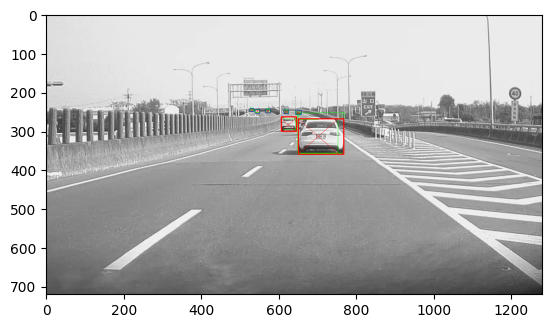

DONE IVAvalid_for_NCTU/day/c32b95371b6b-SOS20230226-143946-2887


In [40]:
weights_path = 'weights/DA_B4_N1_50.pkl'
device = torch.device('cpu') # 選gpu的index
checkpoint = torch.load(weights_path, map_location=device) #if training on 2 GPU, mapping on the same device
normalize_type = checkpoint['normal']
bin_num = checkpoint['bin']
angle_per_class = 2*np.pi/float(bin_num)

my_vgg = vgg.vgg19_bn(weights='DEFAULT').to(device)
model = Model(features=my_vgg.features, bins=bin_num).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# for img processing
if normalize_type == 0:
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
if normalize_type == 1:
    normalize = transforms.Normalize(mean=[0.596, 0.612, 0.587], std=[0.256, 0.254, 0.257])
process = transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize([224,224], transforms.InterpolationMode.BICUBIC), 
                              normalize])

ELAN_averages = ClassAverages(average_file='all_ELAN_class_averages.txt')
cam_to_img = np.array([
        [1.418667e+03, 0.000e+00, 6.4e+02, 0],
        [0.000e+00, 1.418867e+03, 3.6e+02, 0],
        [0.000e+00, 000e+00, 1.0e+00, 0] ])
class_dict = {8:'truck', 9:'car', 10:'motor', 11:'bike'}
# EVAL
model.eval()

os.makedirs(os.path.join(folder,'reg_images'), exist_ok=True)
for i in range(len(img_paths)):
    path = os.path.join(folder, img_paths[i])
    save_path = path.replace('images', 'reg_images')
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    label_dict = label_dicts[i]
    result_dict = dict()
    result_dict['alpha'] = list()
    result_dict['dimension'] = list()
    result_dict['location'] = list()
    for j in range(len(label_dict['labels'])):
        difficulty = label_dict['difficulties'][j] # 1 is hard to distinguish
        if difficulty == 0:
            color = (255, 0, 0)
            line_width = 2
        else:
            color = (0, 0, 255)
            line_width = 1
        class_ = class_dict[label_dict['labels'][j]] # 5:行人,6:機車騎士,7:腳踏車騎士,8:大車,9:小車,10:機車,11:腳踏車
        object_id = label_dict['id'][j] # for tracking
        box_2d = label_dict['boxes'][j]
        box_2d = [[box_2d[0], box_2d[1]], [box_2d[2],box_2d[3]]]
        left_top = box_2d[0]
        right_btm = box_2d[1]
        
        crop = img[left_top[1]:right_btm[1]+1, left_top[0]:right_btm[0]+1] 
        crop = process(crop) 
        crop = torch.stack([crop]).to(device)
        
        [RESIDUALs, BIN_CONFs, delta_DIMs] = model(crop)
        bin_argmax = torch.max(BIN_CONFs, dim=1)[1]
        orient_residual = RESIDUALs[torch.arange(len(RESIDUALs)), bin_argmax] 
        Alphas = angle_per_class*bin_argmax + orient_residual #mapping bin_class and residual to get alpha
        alpha_Elan = float(Alphas[0].data)
        alpha_Elan = round(angle_correction(alpha_Elan),2)
        dim_Elan = delta_DIMs.cpu().data.numpy()[0, :]
        dim_Elan += ELAN_averages.get_item(class_)
        dim_Elan = round_list(dim_Elan)
        theta_ray = calc_theta_ray(img.shape[1], box_2d, cam_to_img)
        loc, ry = plot_regressed_3d_bbox(img, cam_to_img, box_2d, dim_Elan, alpha_Elan, theta_ray, j)
        loc = round_list(loc)
        print(j, difficulty)
        print(loc, round(ry,2))
        result_dict['alpha'].append(alpha_Elan)
        result_dict['dimension'].append(dim_Elan)
        result_dict['location'].append(loc)
        cv2.rectangle(img, left_top, right_btm, color, line_width)
    #plt.imsave(save_path, img)
    plt.imshow(img)
    plt.show()
    break
print(f'DONE {folder}')

In [39]:
def round_list(list_, float_point=2):
    foo = list()
    for i in range(len(list_)):
        new_val = round(float(list_[i]), float_point)
        foo.append(new_val)
    return foo

In [37]:
type(result_dict['dimension'][0][0])
print(result_dict)

{'alpha': [-1.6, -1.59, -1.5, -1.57, -1.51, -1.52, -1.49], 'dimension': [[1.55, 1.8, 4.02], [1.53, 1.81, 3.98], [1.06, 1.43, 2.58], [1.08, 1.54, 2.77], [1.16, 1.51, 2.78], [1.32, 1.6, 2.98], [1.32, 1.61, 3.22]], 'location': [[1.08, -0.81, 23.22], [-0.68, -3.66, 67.49], [-2.54, -13.54, 176.34], [1.18, -10.87, 144.87], [-8.92, -14.67, 187.62], [-13.66, -15.89, 204.15], [-20.82, -21.77, 271.0]]}


In [41]:

import json

with open('data.json', 'w') as fp:
    json.dump(result_dict, fp)